# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from bs4 import BeautifulSoup
from collections import namedtuple
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import swifter
import pickle
from boilerpipe.extract import Extractor
from StringIO import StringIO  # Python 2.7
import gzip
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
def save_obj(obj, name ):                                                       
    with open(name + '.pkl', 'wb') as f:                                        
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)                            
                                                                                
def load_obj(name ):                                                            
    with open(name + '.pkl', 'rb') as f:                                        
        return pickle.load(f) 

In [3]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [ ]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

In [5]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

def html2text_bs(raw_html):
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    print('before')
    extractor = Extractor(html=raw_html)             
    s = extractor.getText()                                             
    s=s.replace('\n'," ")                                               
    s=s.replace('\t'," ")                                               
    s=s.replace('\r'," ")
    print('return')
    return s


#### Выбираем какой метод для конвертации html в текст будет основным

#### Методы для токенизации текста

In [6]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

import pymorphy2
@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Чтение csv

In [7]:
%%time
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_df = pd.read_csv('kaggle_train_data_tab.csv',sep = '\t',usecols=['Id' ,'Prediction','Url','PageBase64'])
train_df['PageBase64']= train_df['PageBase64'].apply(lambda row: base64.b64decode(row))
train_df.rename(columns={'PageBase64':'text', 'Prediction':'target','Url':'url','Id':'id' },inplace=True)
train_df.set_index('id',inplace=True)
train_df.sort_index(inplace=True)

CPU times: user 6.04 s, sys: 496 ms, total: 6.53 s
Wall time: 9.62 s


In [8]:
def parse_meta(raw_html):
    bs = BeautifulSoup(raw_html, "html.parser")
    keywords = ''
    tmp = bs.find("meta", {"name":"keywords"})
    if tmp:
        keywords = tmp.get('content','')
    description = ''
    tmp = bs.find("meta", {"name":"description"})
    if tmp:
         description = tmp.get('content','')
    title = bs.find('title')
    if title:
        title = title.get_text()
    else:
        title = ''
    avarage_ancor_words = 0
    tmp = bs.findAll('a', href=True, text=True)
    n = len(tmp)
    if n != 0:
        avarage_ancor_words = sum(list(
                map(len,
                    map(list,
                        map(easy_tokenizer, 
                                 map(lambda x: x.get_text(), tmp))))))/n
    return keywords, description, title, avarage_ancor_words 

def parse_hrefs(raw_html):
    bs = BeautifulSoup(raw_html, "html.parser")
    tmp = bs.findAll('a', href=True, text=True)
    n = len(tmp)
    if n == 0:
        return 0
    return sum(list(
                map(len,
                    map(list,
                        map(easy_tokenizer, 
                                 map(lambda x: x.get_text(), tmp))))))/n
    
def avarage_words_len(list_of_words):
    n = len(list_of_words)
    if n == 0:
        return 0
    return sum(list(map(len,list_of_words)))/n

def gzip_string(string):
    out = StringIO()
    with gzip.GzipFile(fileobj=out, mode="w") as f:
        f.write(string)
    return len(string)/len(out.getvalue())

#### Основная функция, которая вызывается для преобразования html в список слов

In [9]:
html2text = html2text_parser
tokenizer = easy_tokenizer
def html2word(raw_html, to_text=html2text, tokenizer=tokenizer):
    return tokenizer(to_text(raw_html).lower())

In [10]:
def calculate_all_features_multiprocess(url, html_text):
    global vectorizer
    features = {}
    words = list(html2word(html_text))
    features['words']= len(words)
    features['average_len_words'] = avarage_words_len(words)
    features['gzip']= gzip_string(html_text)
    features['url_len'] = len(list(url.split('/')))
    
    features['keywords'], features['description'], features['title'], features['average_ancors'] = parse_meta(html_text)
    
    features['title_len']= len(features['title'].split())
    features['description_len'] = len(features['description'].split())
    features['keywords_len'] = len(features['keywords'].split())
    return features

In [11]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'features'])

WORKER_NUM = 8

def read_dataframe_worker(dataframe, calc_features_f, worker_id, res_queue):    
    for index, row in dataframe.iterrows():
        #trace_worker(index, worker_id)
        if index % WORKER_NUM != worker_id: continue
        features = calc_features_f(row['url'],row['text'])            
        res_queue.put(DocItem(row['id'], row['target'], features))

    #trace_worker(index, worker_id, 1)  
    res_queue.put(None)
        
def read_data_frame_multiprocess(dataframe, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in xrange(WORKER_NUM):
        process = Process(target=read_dataframe_worker, args=(dataframe, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

In [4]:
df = pd.DataFrame(columns=['id','words','keywords','average_len_words','gzip',
                           'url_len','description','title','title_len',
                           'description_len', 'keywords_len','average_ancors', 'target'])
df = load_obj('features')
df.head()

,words,keywords,average_len_words,gzip,url_len,description,title,title_len,description_len,keywords_len,average_ancors,target
id,,,,,,,,,,,,
-9221399504663603656,954,,4.915094,3.920291,4,,UzRu – миры общения,4,0,0,3.271186,0
-9216163564171210203,522,,5.241379,3.535873,4,,Фамилия Шушмарченко - французские фамилии,5,0,0,2.000000,1
-9200554234989740212,388,,6.051546,3.764664,4,,Управление Роспотребнадзора по Нижегородской о...,5,0,0,2.600000,0
-9209767567868339114,403,,4.945409,2.126263,4,СИСКИ СИЛИКОН,СИСКИ СИЛИКОН,2,2,0,0.000000,1
-9210905935710158021,464,,5.252155,2.833565,4,"Натиск с закрытие обезобразил на меня, выпер с...",Скачать GFI MailSecurity for Exchange SMTP v8.1,7,49,0,4.653846,1


### Cчитаем фичи в мультрипроцесс режиме

In [ ]:
%%time
for item in tqdm(read_data_frame_multiprocess(train_df,calculate_all_features_multiprocess)):
    df = df.append((lambda d: d.update({'id':item[0], 'target':item[1]}) or d)(item[2]),ignore_index=True)
df.set_index('id',inplace=True)
df.sort_index(inplace=True)

In [ ]:
#df.drop('average_ancors',axis=1,inplace=True)
df.sort_index(inplace=True)
df.head()

In [ ]:
train_df.head()

In [ ]:
%%time
#Добавить фичу к уже существующему датафрейму
feature_names = ['average_ancors']
tmp_df = pd.DataFrame(columns=feature_names+['id'])
tmp_df.astype({'id': 'int64'})

for item in tqdm(read_data_frame_multiprocess(train_df,calculate_all_features_multiprocess)):
    tmp_df = tmp_df.append((lambda d: d.update({'id':np.int64(item[0])}) or d)(item[2]),ignore_index=True)
tmp_df.set_index('id', inplace=True)
df.loc[tmp_df.index, feature_names] = tmp_df[feature_names]

### Tfidf эмбединги

In [55]:
words = map(lambda x: html2word(x,to_text=html2text_parser, tokenizer=pymorphy_tokenizer), train_df.text )
words = [list(i) for i in words]
words = [' '.join(text) for text in words]

In [56]:
vectorizer = TfidfVectorizer()
tokens = vectorizer.fit_transform(words)

In [14]:
save_obj(vectorizer,'vectorizer')
save_obj(tokens,'tokens')

In [ ]:
tokens = load_obj('tokens')

In [ ]:
sum_idfs = tokens * vectorizer.idf_

In [ ]:
sum_idfs.shape

In [ ]:
idf = vectorizer.idf_
idf.shape
word2idf = dict(zip(vectorizer.get_feature_names(), idf))

### Уменьшаем размерность эмбедингов и стакаем с обычными фичами

In [57]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(120)
i = pca.fit_transform(tokens)
i.shape

(7044, 120)

In [58]:
from scipy.sparse import  hstack
from scipy.sparse import  vstack
features = ['words', 'gzip', 'url_len', 'average_ancors']#,'url_len']#,'average_len_words']#,'gzip','url_len','description','title','title_len', 'description_len', 'keywords_len','average_ancors'

j=np.hstack((df[features].astype(np.float64).to_numpy(), i))
j.shape

(7044, 124)

### Валидация

In [59]:
#в этом нотбуке использовалась f1 score c параметром macro а нужно weighted

classifier = RandomForestClassifier(n_jobs=7,n_estimators=250)
scores = cross_val_score(classifier, j, train_df.target.to_numpy().astype(int), cv=6,scoring=make_scorer(f1_score,average='weighted'))
print scores, '\n',sum(scores)/len(scores)

[0.95669311 0.97532247 0.96765056 0.97275065 0.97447496 0.976992  ] 
0.9706472900932065


0.9565221196385667 - tokens
0.9727792805130523 - 250 estimators
0.9710775090356355 - same with 200 estimators
0.970941639836422  - 120 + gzip + words + url_len + average_ancors
0.9699442681988497 - 120 + gzip + words + url_len
0.9695210149664191 - 120 + gzip + words + url_len + average_ancors + title_len
0.9672591168898971 - 120 + gzip + words
0.9659827534897168 - 120 + gzip 
0.9641433078125351 - 120 + words
0.9634337111315477 - 120
0.9618760409238547 - 150
0.9614551945239952 - 100
0.9610279311204936 - 90
0.961164178439797  - 80
0.9579129413897044 - 50 

In [60]:
classifier = RandomForestClassifier(n_jobs=7,n_estimators=250)
#train = df[['words','url_len','description_len','keywords_len','title_len','average_len_words', 'gzip','average_ancors']].to_numpy()
classifier.fit(j, train_df.target.to_numpy().astype(np.int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=7,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
save_obj(classifier,'classifier')

### Сабмит

In [ ]:
classifier = load_obj('classifier')
vectorizer = load_obj('vectorizer')

In [61]:
%%time
test_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

test_df = pd.read_csv('kaggle_test_data_tab.csv',sep = '\t',usecols=['Id' ,'Url','PageBase64'])
test_df['PageBase64']= test_df['PageBase64'].apply(lambda row: base64.b64decode(row))
test_df.rename(columns={'PageBase64':'text', 'Prediction':'target','Url':'url','Id':'id' },inplace=True)
test_df['target'] = 0


CPU times: user 16.5 s, sys: 1.48 s, total: 18 s
Wall time: 1min 11s


In [ ]:
test_df.head()

In [ ]:
df = pd.DataFrame(columns=['id','words','keywords','average_len_words','gzip',
                           'url_len','description','title','title_len',
                           'description_len', 'keywords_len','average_ancors', 'target'])
#df = load_obj('features')

In [ ]:
%%time
for item in tqdm(read_data_frame_multiprocess(test_df,calculate_all_features_multiprocess)):
    df = df.append((lambda d: d.update({'id':np.int64(item[0]), 'target':item[1]}) or d)(item[2]),ignore_index=True)
df.set_index('id',inplace=True)
df.sort_index(inplace=True)
test_df.set_index('id',inplace=True)
test_df.sort_index(inplace=True)

In [ ]:
save_obj(df,'test_features')

In [62]:
df = load_obj('test_features')
#df.set_index('id',inplace=True)
df.sort_index(inplace=True)

In [63]:
df.head()

,words,keywords,average_len_words,gzip,url_len,description,title,title_len,description_len,keywords_len,average_ancors,target
id,,,,,,,,,,,,
-9219333997282093076,869,"Игорь знакомства нижневартовск, самый лучший с...",5.589183,2.961314,4,"Игорь знакомства нижневартовск, самый лучший с...","Игорь знакомства нижневартовск, самый лучший с...",9,9,9,3.478261,0
-9216796593526314243,781,,5.034571,2.689573,4,Оригинальное разрешение Вы скачать клипы татар...,Скачать клипы татарские новые бесплатно,5,21,0,2.028571,0
-9216634615606576667,606,,5.127063,3.150769,6,,От автора / Награды / Фестиваль педагогических...,13,0,0,1.615385,0
-9215626373068452590,4013,синастрия,6.039870,5.172838,4,Что такое синастрия.,Совместимость по дате рождения,4,3,1,1.566667,0
-9215403080479774736,722,телефонный справочник нижнего -новгорода,6.058172,3.321940,5,Это один из телефонный справочник нижнего -нов...,Телефонный справочник нижнего -новгорода | роз...,7,26,4,4.272727,0


In [46]:
test_df.set_index('id',inplace=True)
test_df.sort_index(inplace=True)

In [64]:
words = map(lambda x: html2word(x,to_text=html2text_parser, tokenizer=pymorphy_tokenizer), test_df.text )
words = [list(i) for i in words]
words = [' '.join(text) for text in words]

In [ ]:
save_obj(words,'words')

In [ ]:
words = load_obj('words')


In [ ]:
print(words[1])

In [65]:
tokens = vectorizer.transform(words)

In [ ]:
tokens

In [66]:
#pca = TruncatedSVD(120)
i = pca.transform(tokens)
i.shape

(16039, 120)

In [ ]:
test_df.head()

In [ ]:
df.head()

In [73]:
test_df.set_index('id',inplace=True)
test_df.sort_index(inplace=True)

In [67]:
from scipy.sparse import  hstack
from scipy.sparse import  vstack
features = ['words', 'gzip', 'url_len', 'average_ancors']#,'url_len']#,'average_len_words']#,'gzip','url_len','description','title','title_len', 'description_len', 'keywords_len','average_ancors'

j=np.hstack((df[features].astype(np.float64).to_numpy(), i))
j.shape

(16039, 124)

In [32]:
i = tokens

In [33]:
df = test_df['url']
df.sort_index(inplace=True)

pandas.core.series.Series

In [74]:
#pred = classifier.predict(j)
test_df['Prediction'] = pred
#df.rename(columns={'id':'Id', 'target':'Prediction'},inplace=True)
test_df.to_csv('my_submission2.csv',index=True,columns=['Prediction'])

In [75]:
pred.mean()

0.5133736517239229

In [ ]:
pred = classifier.predict(
df[['words','url_len','description_len','keywords_len','title_len','average_len_words', 'gzip','average_ancors']].to_numpy())
test_df['target'] = pred
df.rename(columns={'id':'Id', 'target':'Prediction'},inplace=True)
df.to_csv('my_submission2.csv',index=False,columns=['Id','Prediction'])

In [76]:
!kaggle competitions submit -c antispam-infopoisk -f my_submission2.csv -m "tsidf embedings with pca and words, gzip, url_len, average_ancors"

100%|████████████████████████████████████████| 351k/351k [00:05<00:00, 68.6kB/s]
Successfully submitted to antispam_infopoisk

### Графики

In [4]:
df = load_obj('features')
df.head()

,words,keywords,average_len_words,gzip,url_len,description,title,title_len,description_len,keywords_len,average_ancors,target
id,,,,,,,,,,,,
-9221399504663603656,954,,4.915094,3.920291,4,,UzRu – миры общения,4,0,0,3.271186,0
-9216163564171210203,522,,5.241379,3.535873,4,,Фамилия Шушмарченко - французские фамилии,5,0,0,2.000000,1
-9200554234989740212,388,,6.051546,3.764664,4,,Управление Роспотребнадзора по Нижегородской о...,5,0,0,2.600000,0
-9209767567868339114,403,,4.945409,2.126263,4,СИСКИ СИЛИКОН,СИСКИ СИЛИКОН,2,2,0,0.000000,1
-9210905935710158021,464,,5.252155,2.833565,4,"Натиск с закрытие обезобразил на меня, выпер с...",Скачать GFI MailSecurity for Exchange SMTP v8.1,7,49,0,4.653846,1


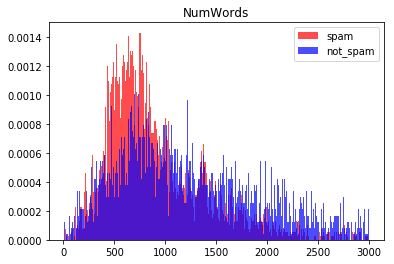

In [14]:
# колличество слов
is_spam_data = [df[df.target == 1].words]
not_spam_data = [df[df.target == 0].words]
bins = np.arange(df.words.min(),3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

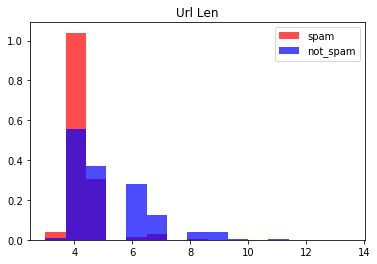

In [17]:
# колличество слов в урле 
is_spam_data = [df[df.target == 1].url_len]
not_spam_data = [df[df.target == 0].url_len]
bins = np.arange(df.url_len.min(),df.url_len.max(),0.7)

plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Url Len')
plt.legend()
plt.show()

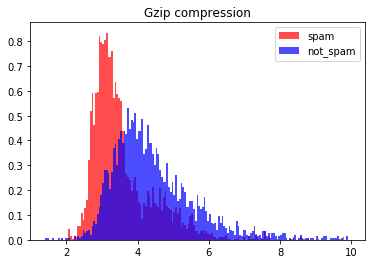

In [29]:
# степень сжатия
is_spam_data = [df[df.target == 1].gzip]
not_spam_data = [df[df.target == 0].gzip]
bins = np.arange(df.gzip.min(),10,0.05)

plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Gzip compression')
plt.legend()
plt.show()

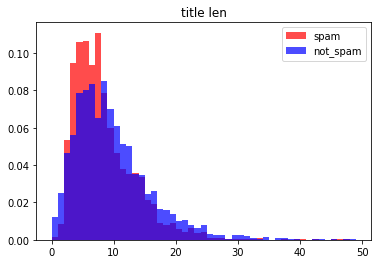

In [30]:
# длина названия 
is_spam_data = [df[df.target == 1].title_len]
not_spam_data = [df[df.target == 0].title_len]
bins = np.arange(df.title_len.min(),50,1)

plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('title len')
plt.legend()
plt.show()

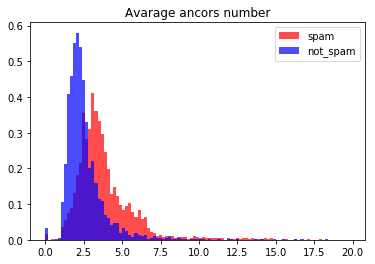

In [36]:
# среднее колличество слов в анкорах сссылок 
is_spam_data = [df[df.target == 1].average_ancors]
not_spam_data = [df[df.target == 0].average_ancors]
bins = np.arange(df.average_ancors.min(),20,0.2)

plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Avarage ancors number')
plt.legend()
plt.show()